# Modules

In [1]:
import pandas as pd, os, warnings, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, scipy.stats as ss
from tqdm import tqdm_notebook
from google.cloud import bigquery
from IPython.core.display import HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./thinkmatch-test-f6985d30d279.json"

client = bigquery.Client(project = "thinkmatch-test")
data = "bigquery-public-data.iowa_liquor_sales"

def gcp(sql):
    query = client.query(sql)
    results = query.result()
    
    return results.to_dataframe()

# Data Overview and Manipulation

## Data set schema

In [18]:
query = f'''SELECT *
FROM `{data}.INFORMATION_SCHEMA.TABLES`
'''

print("Data schema :\n")
display(gcp(query))

Data schema :



,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time
0,bigquery-public-data,iowa_liquor_sales,sales,BASE TABLE,YES,NO,2019-05-08 19:21:49.292000+00:00


This dataset only has one table, which is _sales_.

## Table description

In [5]:
query = f'''SELECT *
FROM `{data}.sales`
'''

# data = gcp(query)
print("Number of observations : ", len(data), "\n")

dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Variables description :")
display(pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
]))

Number of observations :  20546005 

Variables description :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Samples
0,invoice_and_item_number,object,0,0.00,20546005,"[INV-31053300068, INV-05196600115]"
1,date,object,0,0.00,2222,"[2014-09-08, 2019-08-22]"
2,store_number,int64,0,0.00,2534,"[5117, 4867]"
3,store_name,object,0,0.00,2689,"[Casey's General Store #2896 / Ankeny, United ..."
4,address,object,79927,0.39,3754,"[437, SULLIVAN AVE, 840, E LE CLAIRE RD]"
5,city,object,79926,0.39,839,"[West Point, Cascade]"
6,zip_code,object,79971,0.39,928,"[51104, 52042]"
7,store_location,object,1970280,9.59,2015,"[POINT (-93.717068 41.764009), POINT (-94.8616..."
8,county_number,float64,156731,0.76,100,"[39.0, 12.0]"
9,county,object,156729,0.76,202,"[EMMET, Humboldt]"


_date_ variable has object data type when it should have _datetime_ type. Missing values are mainly exist in city or county related variables. We would analyze this data set based on the store's city location because _city_ has lower administrative level than _county_. It enables us to analyze the liquor sales to the smallest level and hence producing more segmented analysis.

## Changing _date_ data type

In [150]:
data["date"] = pd.to_datetime(data["date"])

## Handling missing values in _city_

In [49]:
display(data.sample(5))

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
14103712,S17430500035,2014-02-17,2591,Hy-Vee Wine and Spirits / Atlantic,1602 E. 7TH ST.,ATLANTIC,50022,POINT (-94.990031 41.403856),15.0,Cass,...,16518,Ancient Age Bourbon,6,1750,11.80,17.70,6,106.20,10.5,2.77
8679258,S08471600002,2012-10-22,4255,FAREWAY STORES #058 / ORANGE CITY,512 8TH SE,ORANGE CITY,51041,NaN,84.0,Sioux,...,38008,Smirnoff Vodka 80 Prf Pet,6,1750,13.50,20.74,6,124.44,10.5,2.77
7666609,S18992400001,2014-05-15,4829,Central City 2,1501 MICHIGAN AVE,DES MOINES,50314,POINT (-93.613739 41.60572),77.0,Polk,...,64147,Aperol,6,750,12.25,18.38,18,330.84,13.5,3.57
17328495,S15915900001,2013-11-23,4945,Osage Liquors,"508, MAIN ST",OSAGE,50461,POINT (-92.814028 43.284116),66.0,Mitchell,...,15626,Jameson,12,750,14.49,21.74,12,260.88,9.0,2.38
9747220,S32686200084,2016-06-06,2507,Hy-Vee Food Store #1 / Burlington,939 Angular,Burlington,52601,POINT (-91.110752 40.801889),29.0,Des Moines,...,48105,Hennessy VS,12,375,9.99,14.99,12,179.88,4.5,1.19


We know that _city_ value is the same as _store_name_ value after '/' character, which is stating its origin. But, this pattern doesn't applied to all observations. Thus, we will try to handle the pattern first and look out the result.

In [154]:
for x in tqdm_notebook(data[data["city"].isna()].index):
    try:
        data["city"][x] = re.findall(r"/\s(.*)", data["store_name"][x])[0]
    except:
        pass

print("Missing values left : ", data["city"].isna().sum())

Missing values left :  23012


In [155]:
print("NaN values in city variable :\n")
display(data[data["city"].isna()].head(15))

NaN values in city variable :



,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
887,INV-03377500015,2017-02-21,5142,Smokin' Joe's #13 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,89193,Jose Cuervo Especial Reposado Tequila,48,200,3.00,4.50,2,9.00,0.40,0.11
1126,INV-04401000011,2017-04-17,3805,Washington Street Mini Mart,NaN,NaN,NaN,NaN,NaN,NaN,...,89194,Jose Cuervo Especial Reposado Flask,24,375,5.50,8.25,24,198.00,9.00,2.38
1142,INV-01466300001,2016-11-08,5230,Point Liquor & Tobacco,NaN,NaN,NaN,NaN,NaN,NaN,...,87403,Jose Cuervo Especial Silver,24,375,5.50,8.25,24,198.00,9.00,2.38
1200,INV-00292600005,2016-09-14,5230,Point Liquor & Tobacco,NaN,NaN,NaN,NaN,NaN,NaN,...,89199,Jose Cuervo Especial Reposado Square,12,375,5.50,8.25,12,99.00,4.50,1.19
1418,INV-01403700025,2016-11-04,4478,U S Gas,NaN,NaN,NaN,NaN,NaN,NaN,...,89197,Jose Cuervo Especial Reposado Tequila,12,1000,13.00,19.50,3,56.25,3.00,0.79
8710,INV-02747900044,2017-01-17,5142,Smokin' Joe's #13 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,73055,Rumchata,12,750,12.50,18.75,1,18.75,0.75,0.20
8747,INV-02416700012,2016-12-27,5176,Smokin' Joe's #15 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,68034,Baileys Original Irish Cream,12,375,7.00,10.50,2,21.00,0.75,0.20
8751,INV-05216100075,2017-05-30,5176,Smokin' Joe's #15 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,65200,Tequila Rose Liqueur,12,750,9.99,14.99,1,14.24,0.75,0.20
8762,INV-05488600020,2017-06-13,5176,Smokin' Joe's #15 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,65200,Tequila Rose Liqueur,12,750,9.99,14.99,1,14.24,0.75,0.20
8912,INV-07855100084,2017-10-10,5142,Smokin' Joe's #13 Tobacco & Liquor O,NaN,NaN,NaN,NaN,NaN,NaN,...,73051,Rumchata Mini,12,500,8.87,13.31,1,13.31,0.50,0.13


The rest of missing values observations in _city_ also contain NaN in other important variables, like _county_, _zip_code_, and _store_location_. As a result, we can't extract information in regards to the store's location. Hence we drop these observations.

In [157]:
data.drop(data[data["city"].isna()].index, 0, inplace = True)

print("Missing values left : ", data["city"].isna().sum())
data["city"] = data["city"].apply(lambda x : x.title())

Missing values left :  0


## Slicing based on beneficial cities

Before we move to missing values in _county_, we will slice the data set into important cities only. Important in this context means beneficial business value, which is based on sold bottles per city. We want to analyze potential cities that could enhance our business even more based on their sales track records. However, we also want to focus on cities which have low sales. To do so, we can seperate the data set into two, cities which have high sales and cities which have low sales. This approach aims to:
- Analyze the sales pattern in 'big' cities so we can maintain the high sales.
- Analyze the sales pattern in 'small' cities so we can elaborate and enhance the business approach to maximize and increase the sales.

In [175]:
# Fixing inconsistent city names
for x in data[data["city"] == "Saint Ansgar"].index:
    data["city"][x] = "St. Ansgar"

for x in data[data["city"] == "West Dsm"].index:
    data["city"][x] = "West Des Moines"

for x in data[data["city"] == "Marsha"].index:
    data["city"][x] = "Marshalltown"
    
for x in data[data["city"] == " Dubuque"].index:
    data["city"][x] = "Dubuque"

for x in data[data["city"] == "Humest"].index:
    data["city"][x] = "Humeston"

for x in data[data["city"] == "Urband"].index:
    data["city"][x] = "Urbandale"
    
for x in data[data["city"] == " Coralville"].index:
    data["city"][x] = "Coralville"

In [259]:
print("Cities based on total sold bottles :\n")
temp = data.groupby("city").sum().sort_values("bottles_sold", ascending = False)[["bottles_sold"]].rename(columns = {"bottles_sold" : "Total bottles sold"})
temp.index.name = "City"
display(temp)

print("\nQuantitative report :\n")
display(temp[["Total bottles sold"]].describe())

Cities based on total sold bottles :



,Total bottles sold
City,
Des Moines,26904080
Cedar Rapids,14916815
Davenport,12387503
Waterloo,9126525
Council Bluffs,7282015
...,...
Rudd,1236
Chester,1083
Allerton,697



Quantitative report :



,Total bottles sold
count,4.630000e+02
mean,4.598034e+05
std,1.801920e+06
min,1.200000e+01
25%,1.961850e+04
50%,5.290900e+04
75%,1.929905e+05
max,2.690408e+07


Now we see that not every city produce enough beneficial values to the business. Colorado Springs for example, has number of bottles sold which is nothing compared to Council Bluffs. It's also not even close to the mean (459.803 bottles sold). In respect to this finding, we will create new data sets containing top 10 'high' cities and top 10 'low' cities. This objective is expected to give sellers (vendors) a better understanding of how each group, or even each city, can be maximized using their pattern of behaviour respectively.

## Handling missing values in _category_name_

Before we split our data set, it's better to handle missing values in _category_name_ first. We take this approach because of assumption that certain _category_ which isn't NaN may appear in either high or low cities. If we split out the data set before we fill these missing values, there's a chance we'll miss information for _category_name_ which _category_ isn't NaN. 

In [296]:
temp = {}
for x in data["category"].unique():
    try:
        res = data[data["category"] == x]["category_name"].unique()
        for r in res:
            if type(r) == str:
                temp.update({x : r})
    except:
        pass
    
cat = []
for x in tqdm_notebook(data["category"]):
    try:
        cat.append(temp[x])
    except:
        cat.append(float("NaN"))

data["category_name"] = cat

print("Missing values in category_name : ", data["category_name"].isnull().sum())

Missing values in category_name :  16888


We succeed in filling _category_name_ missing values from 20.000s observations to 16.888 observations. It means there are 16.888 rows that don't have _category_ and _category_name_. We'll drop these rows since they can't provide us category - based analysis.

In [299]:
data.dropna(subset = ["category_name"], inplace = True)

## Data set splitting

In [303]:
high = data[data["city"].isin(temp.iloc[:10].index)]
low = data[data["city"].isin(temp.iloc[-10:].index)]

print("Top 10 high cities :\n")
for x in temp.iloc[:10].index:
    print("-", x)
print("\nNumber of observations : ", len(high), "\n")
    
print("\nTop 10 low cities :\n")
for x in temp.iloc[-10:].index:
    print("-", x)
print("\nNumber of observations : ", len(low))

Top 10 high cities :

- Des Moines
- Cedar Rapids
- Davenport
- Waterloo
- Council Bluffs
- Sioux City
- Iowa City
- West Des Moines
- Dubuque
- Ames

Number of observations :  8122647 


Top 10 low cities :

- Alta Vista
- Morning Sun
- Murray
- Wyoming
- Washta
- Rudd
- Chester
- Allerton
- Alvord
- Colorado Springs

Number of observations :  1772


## Handling missing values in _county_

We could extract the county name from three variables, which are _city_, _zip_code_, and _county_number_. For each missing observations, we will try to search the exact same other observations (based on etiher city, zip code or county number) and fill it with their common county name. But, because _zip_code_ and _county_number_ still have missing values, we can't extract their _county_ because slicing based on NaN will result nothing. Therefore we will slice based on city because on the previous work we successfully fill all its missing values.

In [304]:
temp = {}
for x in high["city"].unique():
    temp.update({x : high[high["city"] == x]["county"].unique()[0]})
    
county = []
for x in tqdm_notebook(high["city"]):
    county.append(temp[x])

high["county"] = county
high["county"] = high["county"].apply(lambda x : x.title())

In [305]:
temp = {}
for x in low["city"].unique():
    temp.update({x : low[low["city"] == x]["county"].unique()[0]})
    
county = []
for x in tqdm_notebook(low["city"]):
    county.append(temp[x])

low["county"] = county
low["county"] = low["county"].apply(lambda x : x.title())

In [306]:
print("County missing values in high cities : ", high["county"].isnull().sum())
print("County missing values in low cities : ", low["county"].isnull().sum())

County missing values in high cities :  0
County missing values in low cities :  0


We finally handled all missing values in _county_.

In [316]:
print("Missing values left in high cities group :\n")
display(high.isnull().sum())

print("\nMissing values left in low cities group :\n")
display(low.isnull().sum())

Missing values left in high cities group :



invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                      6248
city                            0
zip_code                     6247
store_location             847180
county_number               33816
county                          0
category                        0
category_name                   0
vendor_number                   6
vendor_name                     4
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               6
state_bottle_retail             6
bottles_sold                    0
sale_dollars                    6
volume_sold_liters              0
volume_sold_gallons             0
a                               0
dtype: int64


Missing values left in low cities group :



invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              2
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
a                          0
dtype: int64

The low group seems doens't have missing values left. On the other hand, we still have to handle _sale_dollars_, _state_bottle_cost_, _state_bottle_retail_, and _vendor_name_ in high cities group.

## Handling missing values in _sale_dollars_, _state_bottle_cost_, and _state_bottle_retail_

In [318]:
print("Missing values in sale_dollars :\n")
display(high[high["sale_dollars"].isnull()])

Missing values in sale_dollars :



,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,a
254569,S03814000102,2012-01-30,2623,Hy-Vee Food Store #4 / Sioux City,2827 HAMILTON BLVD,Sioux City,51104,POINT (-96.417783 42.519886),97.0,WOODBURY,...,Titos Handmade Mini,5,600,NaN,NaN,2,NaN,1.2,0.32,VODKA 80 PROOF
4482373,S03842900089,2012-01-31,2614,Hy-Vee #3 Food and Drugstore,1823 E KIMBERLY RD,Davenport,52807,POINT (-90.548919 41.55678100000001),82.0,SCOTT,...,Titos Handmade Mini,5,600,NaN,NaN,2,NaN,1.2,0.32,VODKA 80 PROOF
10503795,S03816800149,2012-01-30,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314,POINT (-93.619787 41.60566),77.0,POLK,...,Titos Handmade Mini,5,600,NaN,NaN,1,NaN,0.6,0.16,VODKA 80 PROOF
11015256,S03818000080,2012-01-31,4509,A J'S LIQUOR II,2515 CHAMBERLAIN,Ames,50010,POINT (-93.650838 42.021461),85.0,STORY,...,Titos Handmade Mini,5,600,NaN,NaN,1,NaN,0.6,0.16,VODKA 80 PROOF
12536382,S03831800099,2012-01-31,2629,Hy-Vee Food Store #2 / Council Bluff,1745 MADISON AVE,Council Bluffs,51503,POINT (-95.825137 41.242732),78.0,POTTAWATTA,...,Titos Handmade Mini,5,600,NaN,NaN,3,NaN,1.8,0.48,VODKA 80 PROOF
13399056,S03842900093,2012-01-31,2614,Hy-Vee #3 Food and Drugstore,1823 E KIMBERLY RD,Davenport,52807,POINT (-90.548919 41.55678100000001),82.0,SCOTT,...,Pearl Wedding Cake Vodka Mini,12,500,NaN,NaN,1,NaN,0.5,0.13,Imported Flavored Vodka


Fortunately, observations which have NaN in _sale_dollars_ are the same as observations which have NaN in _state_bottle_cost_ and _state_bottle_retail_. Hence we can easily handle these missing values.

**One important thing, the price of an item is changing over years. So, we must put _date_ as our determinant. We then create new columns containing year and month for each observations to ease our work and deepen our analysis later.**

In [343]:
high["year"], high["month"] = high["date"].apply(lambda x : x.year), high["date"].apply(lambda x : x.month)
low["year"], low["month"] = low["date"].apply(lambda x : x.year), low["date"].apply(lambda x : x.month)

for x in high[high["sale_dollars"].isnull()].index:
    for c in high[(high["item_description"] == high["item_description"][x]) & (high["year"] == high["year"][x])]["state_bottle_cost"].unique():
        if c > 1:
            high["state_bottle_cost"][x] = c

    for r in high[(high["item_description"] == high["item_description"][x]) & (high["year"] == high["year"][x])]["state_bottle_retail"].unique():
        if r > 1:
            high["state_bottle_retail"][x] = r
    
    high["sale_dollars"][x] = high["state_bottle_retail"][x] * high["bottles_sold"][x]

## Handling missing values in _vendor_name_

In [396]:
print("Missing values in vendor_name :\n")
display(high[high["vendor_name"].isnull()][["vendor_number", "vendor_name"]])

Missing values in vendor_name :



,vendor_number,vendor_name
7497284,NaN,NaN
15325686,NaN,NaN
18948969,NaN,NaN
19949799,NaN,NaN


Observations which have NaN in _vendor_name_ also have NaN in their _vendor_number_. Hence, we can't extract information to fill in the values so it's better to drop them.

In [398]:
high.drop(high[high["vendor_name"].isnull()].index, 0, inplace = True)

This step finishes our data wrangling and cleansing. Now we don't have missing values left for important variables. Before we jump into analysis, we shall drop unnecessary columns to make the computation process more efficient.

In [409]:
high.drop(["invoice_and_item_number", "store_number", "address", "zip_code", "store_location", "county_number", "category", "vendor_number", "a", "volume_sold_gallons", "item_number"], 1, inplace = True)
low.drop(["invoice_and_item_number", "store_number", "address", "zip_code", "store_location", "county_number", "category", "vendor_number", "a", "volume_sold_gallons", "item_number"], 1, inplace = True)

print("Missing values left in high cities group : \n")
display(high.isna().sum())

print("\nMissing values left in low cities group : \n")
display(low.isna().sum())

Missing values left in high cities group : 



date                   0
store_name             0
city                   0
county                 0
category_name          0
vendor_name            0
item_description       0
pack                   0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
bottles_sold           0
sale_dollars           0
volume_sold_liters     0
year                   0
month                  0
dtype: int64


Missing values left in low cities group : 



date                   0
store_name             0
city                   0
county                 0
category_name          0
vendor_name            0
item_description       0
pack                   0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
bottles_sold           0
sale_dollars           0
volume_sold_liters     0
year                   0
month                  0
dtype: int64

Finally, we're ready to analyze these cleaned data sets.

# Analysis

Before we go, it's better to check for anomalies in certain columns. We assume that _sale_dollars_ variable is built upon **_state_bottle_retail_ * _bottles_sold_**. But, what if the data set captures an error?

In [264]:
errL_H, countL = {}, 0
errH_H, countH = {}, 0
for r, s, d, i in tqdm_notebook(zip(high["state_bottle_retail"], high["bottles_sold"], high["sale_dollars"], high.index)):
    temp = r * s
    if ((temp) - d) < 0.01:
        errL_H.update({i : 0})
        errH_H.update({i : 0})
    else:
        if temp < d:
            errL_H.update({i : temp})
            countL += 1
        else:
            errH_H.update({i : temp})
            countH += 1
        
print("Inconsistent sale calculation in top 10 highest cities :\n")
print(f"- Sales amount higher than sale_dollars variable : {countH} observations")
print(f"- Sales amount lower than sale_dollars variable : {countL} observations\n")

errL_L, countL = {}, 0
errH_L, countH = {}, 0
for r, s, d, i in tqdm_notebook(zip(low["state_bottle_retail"], low["bottles_sold"], low["sale_dollars"], low.index)):
    temp = r * s
    if ((temp) - d) < 0.01:
        errL_L.update({i : 0})
        errH_L.update({i : 0})
    else:
        if temp < d:
            errL_L.update({i : temp})
            countL += 1
        else:
            errH_L.update({i : temp})
            countH += 1
        
print("Inconsistent sale calculation in top 10 lowest cities :\n")
print(f"- Sales amount higher than sale_dollars variable : {countH} observations")
print(f"- Sales amount lower than sale_dollars variable : {countL} observations")


Inconsistent sale calculation in top 10 highest cities :

- Sales amount higher than sale_dollars variable : 285543 observations
- Sales amount lower than sale_dollars variable : 0 observations




Inconsistent sale calculation in top 10 lowest cities :

- Sales amount higher than sale_dollars variable : 57 observations
- Sales amount lower than sale_dollars variable : 0 observations


This error possibly occurs because of sale programs (discount or things like 'buy 1 get 1') given by certain stores. However, after some checking to the data source, this errors occurs because of human error. The data owner suggests us to renew _bottles_sold_ and _volume_sold_liters_ using **_sale_dollars_ / _state_bottle_retail_ = _bottles_sold_** formula.

>"We have discussed this discrepancy with our DBA who manages the data being sent. They found that the Unit volume was sent instead of bottles. Units can be cases, bottles, or sleeves. We are working to append the sales data to reflect actual bottles. Until then please take Sales/state bottle retail= Bottles sold. This new Bottles sold can be used to find the true liters and gallons sold. The data from September 16' to Current 2018 is affected. We will comment an update when the bottles column has been fixed and the data has been appended."

**Source : Replies from Alcoholic Beverages Division (Commerce) in _Discuss_ tab in https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/data**

Hence we'll update those variables with new calculation.

In [302]:
soldB, soldL = [], []
for i, v in tqdm_notebook(errH_H.items()):
    if v == 0:
        soldB.append(high["bottles_sold"][i])
        soldL.append(high["volume_sold_liters"][i])
    else:
        soldB.append(round((high["sale_dollars"][i] / high["state_bottle_retail"][i]), 2))
        soldL.append(round(((soldB[i] * high["bottle_volume_ml"][i]) / 1000), 2))

high["bottles_sold"] = soldB
high["volume_sold_liters"] = soldL

soldB, soldL = [], []
for i, v in tqdm_notebook(errH_L.items()):
    if v == 0:
        soldB.append(low["bottles_sold"][i])
        soldL.append(low["volume_sold_liters"][i])
    else:
        soldB.append(round((low["sale_dollars"][i] / low["state_bottle_retail"][i]), 2))
        soldL.append(round(((soldB[i] * low["bottle_volume_ml"][i]) / 1000), 2))

low["bottles_sold"] = soldB
low["volume_sold_liters"] = soldL

## Top 10 Highest Cities

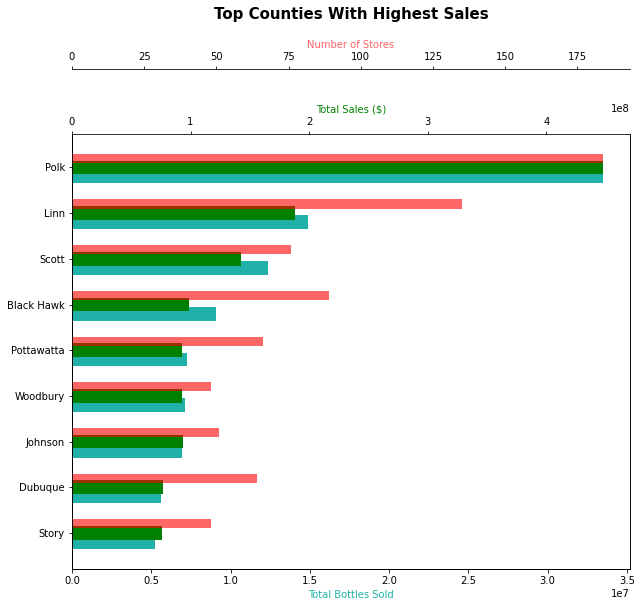

In [286]:
temp = high.groupby("county").sum()[["bottles_sold", "sale_dollars"]].sort_values("bottles_sold").reset_index()
res = []
for x in temp["county"]:
    res.append(len(high[high["county"] == x]["store_name"].unique()))
temp["stores"] = res

fig, ax = plt.subplots(figsize = (10, 8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.barh(temp.index - .2, temp["bottles_sold"],
       color = "lightseagreen",
       height = 0.3,
       linewidth = 1)

ax.set_title("Top Counties With Highest Sales", fontdict = {'fontsize': 15,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.25)

ax.set_xlabel(
    "Total Bottles Sold",
    fontdict = {
        "size" : 10,
        "color" : "lightseagreen"
    }
    )

ax2 = ax.twiny()
ax2.barh(temp.index, temp["sale_dollars"],
       color = "green",
       height = 0.3,
       linewidth = 1)

ax2.set_xlabel(
    "Total Sales ($)",
    fontdict = {
        "size" : 10,
        "color" : "green"
    }
    )

ax3 = ax.twiny()
ax3.barh(temp.index + .2, temp["stores"],
       color = "red",
       alpha = 0.6,
       height = 0.2,
       linewidth = 1)

ax3.set_xlabel(
    "Number of Stores",
    fontdict = {
        "size" : 10,
        "color" : "red",
        "alpha" : 0.6
    }
    )

ax3.spines["top"].set_position(("axes", 1.15))
ax3.spines["top"].set_visible(True)


plt.yticks(([x for x in temp.index]), ([x for x in temp["county"]]))

plt.show()

We see that even number of bottles sold and amount of dollars positively correlate, it's not followed by the same pattern for number of stores. Dubuque has higher customers than Johnson and Woodbury, but it can't surpass their sales. Same phenomenon also occurs in Black Hawk whose sales is under Scott. Customers existence is a very important, and maybe determinant, role in determining sales potential. Although it may not always followed by increment of sales, like what the plot tells us, it can be maximized by further understanding of the market (people) behaviour. A proper approach plus a broad market could lead to higher sales and income. Thus, Dubuque and Black Hawk in this context are very potential.

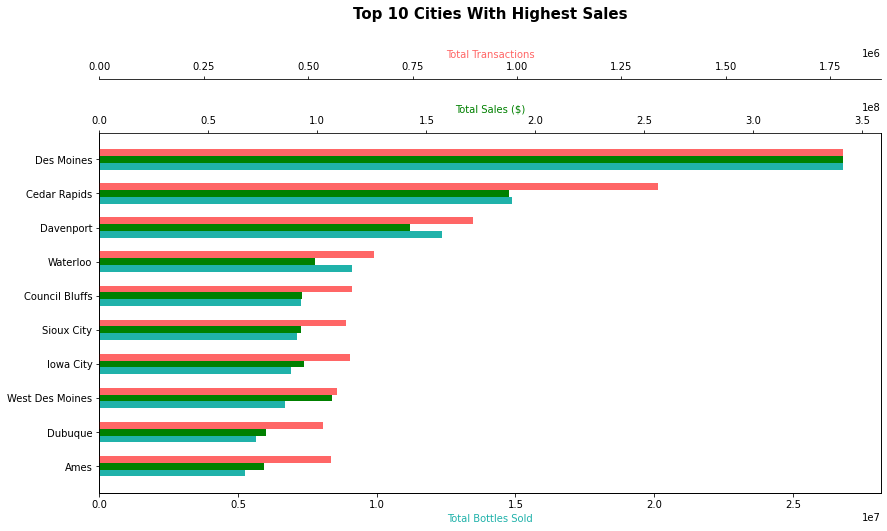

In [303]:
temp = high.groupby("city").sum()[["bottles_sold", "sale_dollars"]].sort_values("bottles_sold").reset_index()
temp_ = high.groupby("city").count()[["date"]].reset_index()
temp = temp.merge(temp_, on = "city")

fig, ax = plt.subplots(figsize = (14, 8))
fig.subplots_adjust(top = 0.75)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.barh(temp.index - .2, temp["bottles_sold"],
       color = "lightseagreen",
       height = 0.2,
       linewidth = 1)

ax.set_title("Top 10 Cities With Highest Sales", fontdict = {'fontsize': 15,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.3)

ax.set_xlabel(
    "Total Bottles Sold",
    fontdict = {
        "size" : 10,
        "color" : "lightseagreen"
    }
    )

ax2 = ax.twiny()
ax2.barh(temp.index, temp["sale_dollars"],
       color = "green",
       height = 0.2,
       linewidth = 1)

ax2.set_xlabel(
    "Total Sales ($)",
    fontdict = {
        "size" : 10,
        "color" : "green"
    }
    )

ax3 = ax.twiny()
ax3.barh(temp.index + .2, temp["date"],
       color = "red",
       alpha = 0.6,
       height = 0.2,
       linewidth = 1)

ax3.set_xlabel(
    "Total Transactions",
    fontdict = {
        "size" : 10,
        "color" : "red",
        "alpha" : 0.6
    }
    )

ax3.spines["top"].set_position(("axes", 1.15))
ax3.spines["top"].set_visible(True)

plt.yticks(([x for x in temp.index]), ([x for x in temp["city"]]))

plt.show()

We see a **nearly complete** positive correlation between amount of bottles sold and amount of sale in dollars for all cities. The only one anomaly occurs in **West Des Moines (WDM)**, where it gained more amount of dollars compared to Iowa City, Sioux City, Council Bluffs, and even Waterloo. It means that customers (stores) in WDM tend to buy **fewer amount of bottles but with more expensive price** than customers in mentioned cities. Besides, this also come up with 4 conclusions and/or assumptions:
- WDM has smaller number of liquor customers than Iowa City, Sioux City, Council Bluffs, and even Waterloo. However, they tend to be more alcoholic than the mentioned cities customers.
- Customers in WDM are most likely richer than customers in mentioned cities.
- The second assumption above is wrong. Instead, higher amount of dollars is influenced by newer liquor trend or liquor consumption habit in WDM. Just like the previous finding (about year), price for certain liquor is increasing throughout the years. Therefore, there's a chance that WDM customers bought liquor in newer year (with increased price) and result in higher amount of sales.

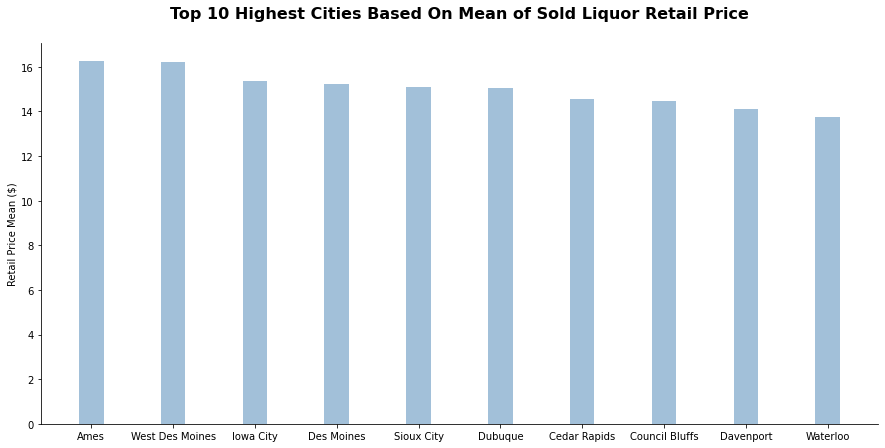

In [297]:
temp = high.groupby("city").mean().sort_values("state_bottle_retail", ascending = False)
fig, ax = plt.subplots(figsize = (15, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.bar(temp.index, temp["state_bottle_retail"],
       color = "steelblue",
       alpha = 0.5,
       width = 0.3,
       linewidth = 1)

plt.title("Top 10 Highest Cities Based On Mean of Sold Liquor Retail Price", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05)

plt.ylabel(
    "Retail Price Mean ($)",
    fontdict = {
        "size" : 10
    }
    )

plt.show()

It's clear now that WDM phenomenon is influenced by its higher retail price compared to Iowa City, Sioux City, Council Bluffs, and Waterloo which have higher rate of sold bottles. Surprisingly Ames, the lowest in sales rate, turns out having the highest mean of retail price. However, because of its low consumption (low bottles sold per transaction even though its transaction rate is slightly higher than Dubuque) Ames can't push up the income. Therefore, it brings up assumption that Ames customers tend to not buy in high amount of bottles because of its high retail price and result in low liquors transaction.

In [328]:
temp = pd.DataFrame({"City" : [x for x in high["city"].unique()], "Customers" : [len(x) for x in [high[high["city"] == c]["store_name"].unique() for c in high["city"].unique()]]}).sort_values("Customers", ascending = False).set_index("City")

print("Number of customers per city :\n")
display(temp)

Number of customers per city :



,Customers
City,
Cedar Rapids,135
Des Moines,132
Waterloo,89
Davenport,76
Council Bluffs,66
Dubuque,64
West Des Moines,52
Iowa City,51
Sioux City,48


Speaking about customers, we got interesting finding here. Des Moines which have the most sales over all cities turns out having a slight fewer number of customers. Same phenomenon occurs in Waterloo and Davenport where Davenport has fewer customers regardless its domination in sales. But, those customers seem more beneficial because we can see a higher rate of transaction throughout the period. Higher transaction also means higher consumption because store would buy new stocks if the old stock nearly sold out.

In [164]:
arrays = [
   [y for y in high["city"].unique() for x in range(2)],
    [y for x in range(10) for y in ["Store", "Transactions"]],
  ]

columns = pd.MultiIndex.from_tuples(list(zip(*arrays)))
temp = pd.DataFrame(columns = columns, index = [x for x in range(5)])

for x in high["city"].unique():
    stores = high[high["city"] == x].groupby("store_name").count()["date"].sort_values(ascending = False)
    temp[x] = pd.DataFrame({"Store" : [x for x in stores.index[:5]], "Transactions" : [x for x in stores.values[:5]]})

print("Highest store distributions per city :\n")
display(temp)

Highest store distributions per city :



Waterloo               \
                                Store Transactions   
0  Hy-Vee Food Store #3 / Waterloo     74131         
1  Hy-Vee Wine and Spirits / Waterloo  69765         
2  Hy-Vee Food Store #2 / Waterloo     50711         
3  Sycamore Convenience                33514         
4  Sam's Club 6514 / Waterloo          28391         

                      West Des Moines               \
                                Store Transactions   
0  Hy-Vee Wine and Spirits / WDM       90136         
1  Hy-Vee #4 / WDM                     85106         
2  Hy-Vee Food and Drug / Grand / WDM  72418         
3  Hy-Vee Food Store #1 / WDM          54272         
4  Wal-Mart 3762 / WDM                 26421         

                      Davenport               \
                          Store Transactions   
0  Hy-Vee #3 Food and Drugstore  73408         
1  Hy-Vee #4 / Davenport         63364         
2  Hy-Vee Wine and Spirits #2    60808         
3  Hy-Vee #5 / Davenport         59258         
4  Hy-Vee Drugstore / Davenport  58079         

                          Cedar Rapids               \
                                 Store Transactions   
0  Hy-Vee #7 / Cedar Rapids             96638         
1  Hy-Vee Food Store #5 / Cedar Rapids  91631         
2  Hy-Vee Food Store #3 / Cedar Rapids  85380         
3  Benz Distributing                    85160         
4  Hy-Vee Food Store #1 / Cedar Rapids  62075         

                          Des Moines               \
                               Store Transactions   
0  Hy-Vee #3 / BDI / Des Moines       173190        
1  Central City 2                     142595        
2  Central City Liquor, Inc.          138404        
3  Hy-Vee Food Store / Fleur / DSM    84095         
4  Hy-Vee Food Store #3 / Des Moines  63338         

                          Sioux City               \
                               Store Transactions   
0  Hy-Vee Food Store #4 / Sioux City  80538         
1  Hy-Vee Food Store #3 / Sioux City  77073         
2  Charlie's Wine and Spirits,        70405         
3  Hy-Vee Food Store / Sioux City     60377         
4  Wal-Mart 3590 / Sioux City         29171         

                             Iowa City               \
                                 Store Transactions   
0  Hy-Vee Wine and Spirits / Iowa City  123166        
1  Hy-Vee Food Store #2 / Iowa City     66153         
2  Hy-Vee Drugstore / Iowa City         54747         
3  Hy-Vee Food Store / Iowa City        52011         
4  Liquor Downtown / Iowa City          35543         

                       Dubuque                                      Ames  \
                         Store Transactions                        Store   
0  Hy-Vee #3 / Dubuque          70194        Hy-Vee Food Store #1 / Ames   
1  Hy-Vee Food Store / Dubuque  69177        Cyclone Liquors               
2  Iowa Street Market, Inc.     63792        Hy-vee  #2 / Ames             
3  Hy-Vee #2 / Dubuque          61665        Hy-Vee  #2 / Ames             
4  Sid's Beverage Shop          49253        A J'S LIQUOR II               

                                       Council Bluffs               
  Transactions                                  Store Transactions  
0  98546        I-80 Liquor / Council Bluffs           60903        
1  91032        Hy-Vee Food Store #2 / Council Bluff   46144        
2  54716        Hy-Vee Food Store #2 / Council Bluffs  45340        
3  45429        Hy-Vee Food Store #1 / Council Bluff   38379        
4  28085        Hy-Vee Food Store #1 / Council Bluffs  36463

Among those customers we've talking about, Hy-Vee is the most distributed store. We can see that either Hy-Vee Fodd Store or Hy-Vee Wine and Spirits are always been in the top customers among 10 highest cities. Therefore, **Hy-Vee** is a very potential and beneficial customers in regards to Iowa liquor's income.

In [358]:
print("Total vendors per city :\n")
temp = high["city"].unique()
temp_ = pd.DataFrame(
    {
        "Total Vendors" : [len(high[high["city"] == x]["vendor_name"].unique()) for x in temp]
    }, index = [x for x in temp]
).sort_values("Total Vendors", ascending = False)

display(temp_)

Total vendors per city :



,Total Vendors
Des Moines,399
Ames,337
Cedar Rapids,328
West Des Moines,291
Iowa City,289
Davenport,275
Waterloo,272
Sioux City,256
Council Bluffs,244
Dubuque,236


Meanwhile, if we're speaking about seller competition, Des Moines should be avoided by new vendor. There's already tight competition and it also means many customers already have their buying partners (trusted vendors). On the other hand, either new or settled vendor, should consider West Des Moiner or Waterloo.

Favorite products based on cities :



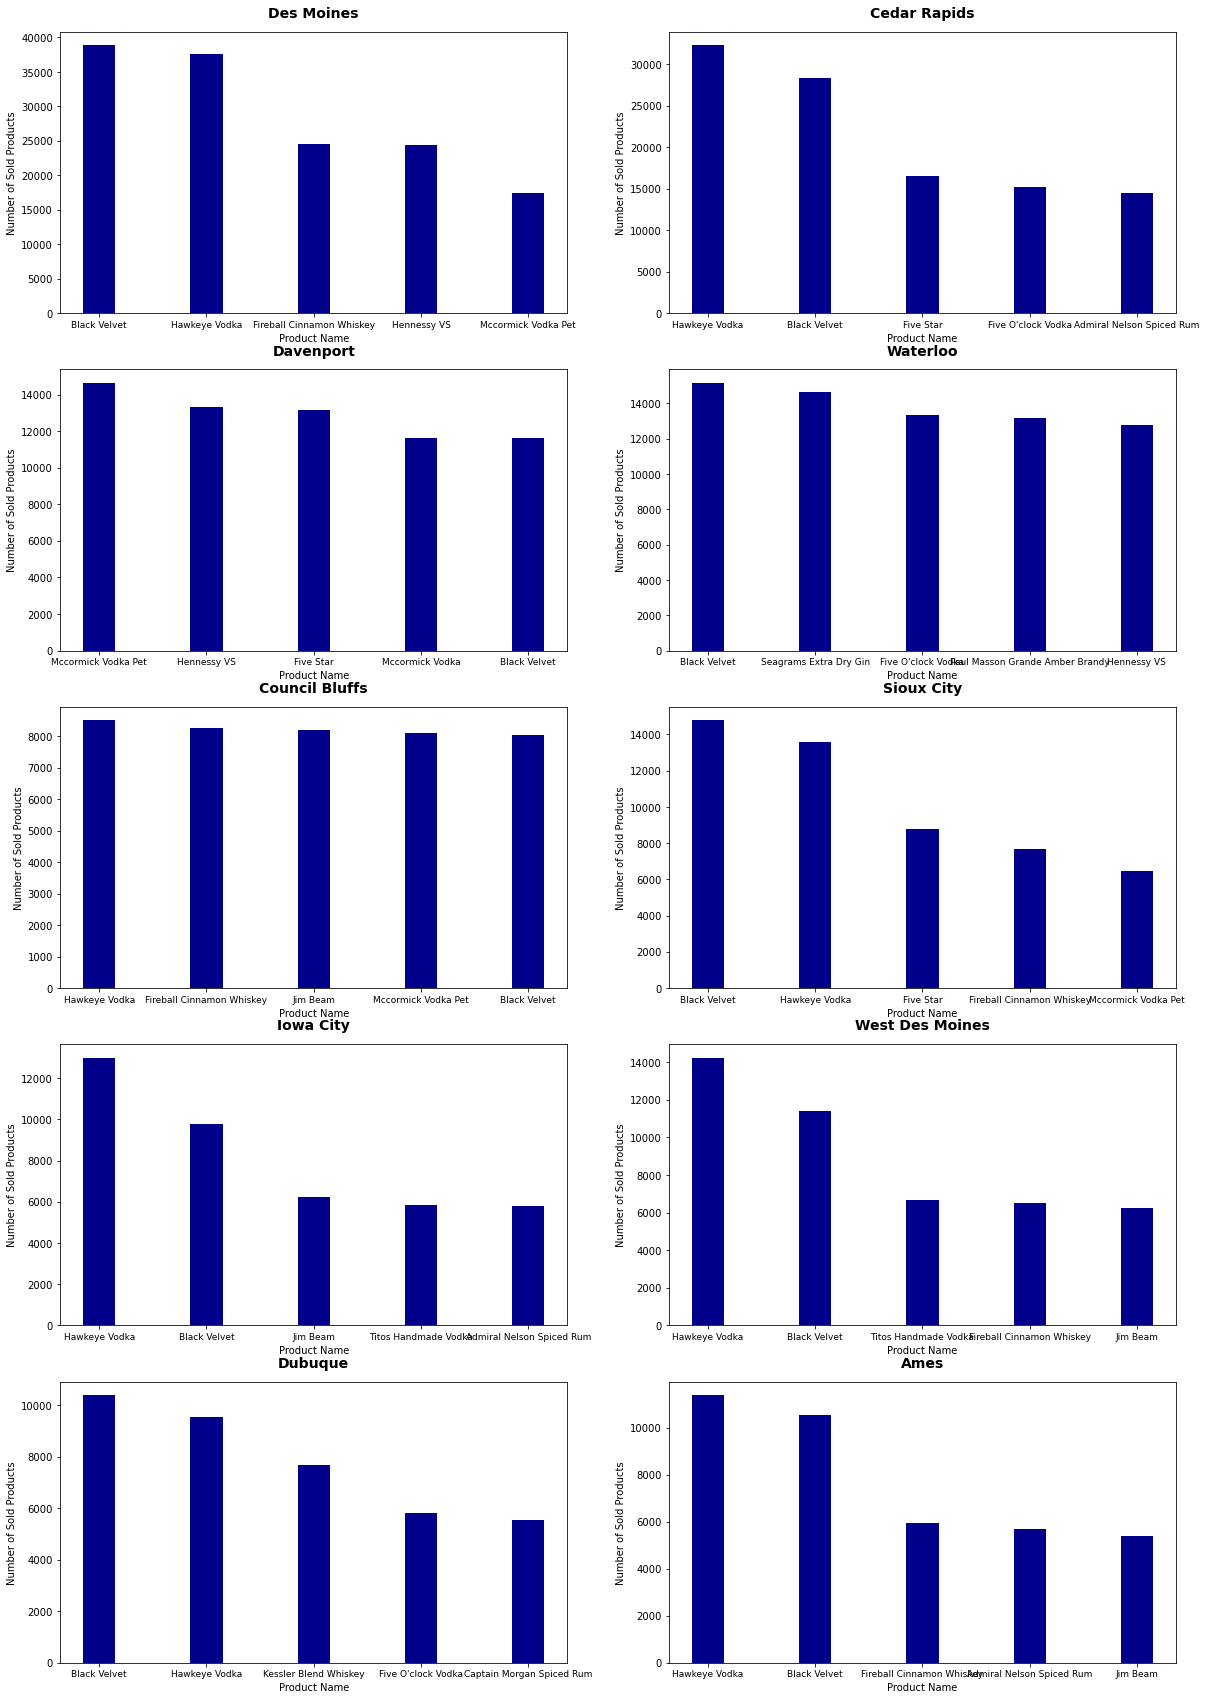

In [197]:
row, col = 0, 0

print("Favorite products based on cities :\n")
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in high.groupby("city").sum()["bottles_sold"].sort_values(ascending = False).index: 
    if col > 1:
        col = 0
        row += 1
        
    temp = high[high["city"] == x].groupby("item_description").count().sort_values("date", ascending = False)[:5]
    
    ax[row][col].bar([x for x in temp.index], [x for x in temp["date"]], width = 0.3, color = "darkblue")
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 14,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Product Name",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Number of Sold Products",
        fontdict = {
            "size" : 10
        }
        )
    
    ax[row][col].set_xticklabels(
            labels = [x for x in temp.index],
            fontdict = {
            "fontsize": "9"
            }
        )
    
    col += 1

Meanwhile, Hawkey Vodka and Black Velvet are the most favorite products in these cities. Only customers in Davenport who don't really love either of these liquors.

**We use products name instead of category name because _category_name_ changes in some years**

>"In 2016 ABD invested into a new all in one system to keep up with demands in technology and sales. Our products team took this as an opportunity to fix our product categories in the database since they hadn't been updated. Many of the categories where there was only few products or were materially close to another category where combined. In summary the old categories were outdated and needed to be re-assessed at the time by management. If you need more information on why categories were condensed and reformed I can put you in contact with our products manager."

**Source : Replies from Alcoholic Beverages Division (Commerce) in _Discuss_ tab in https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/data**

Sales and consumption trend across years based on cities :



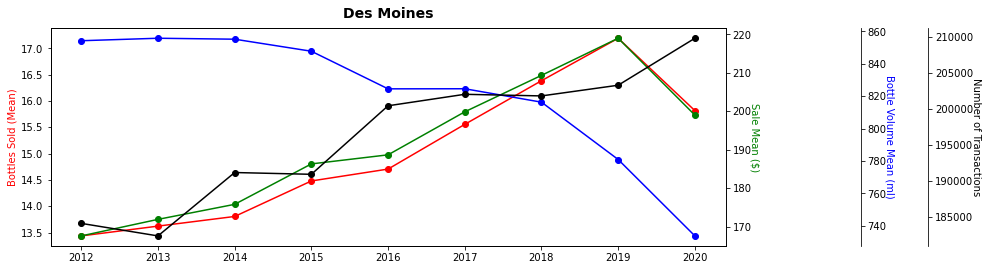

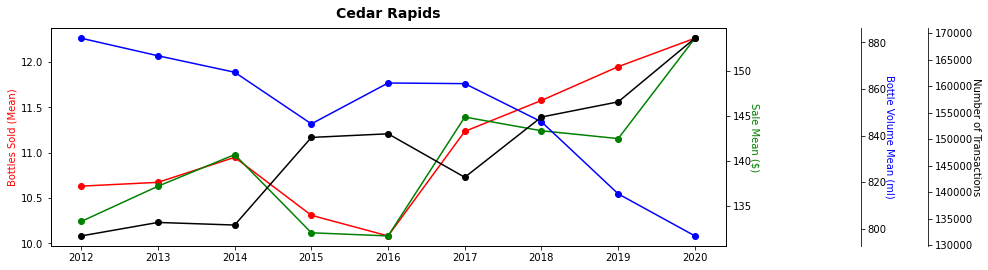

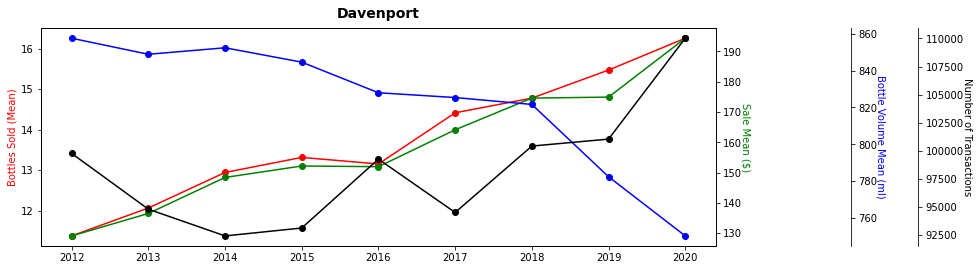

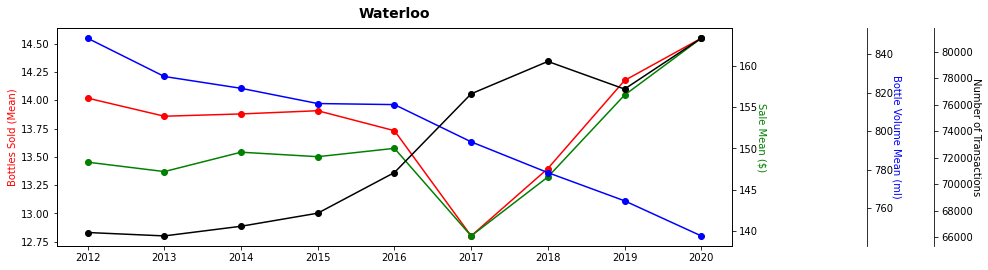

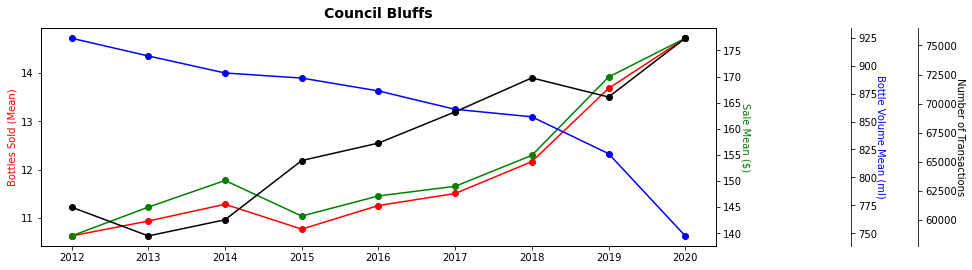

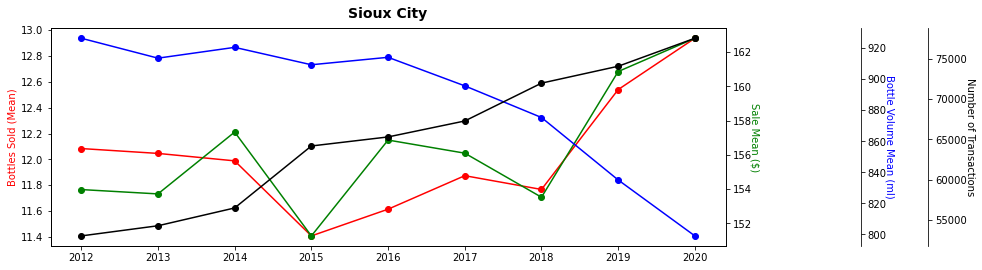

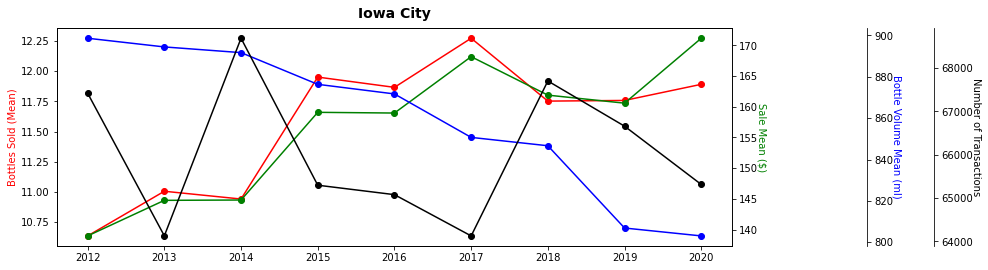

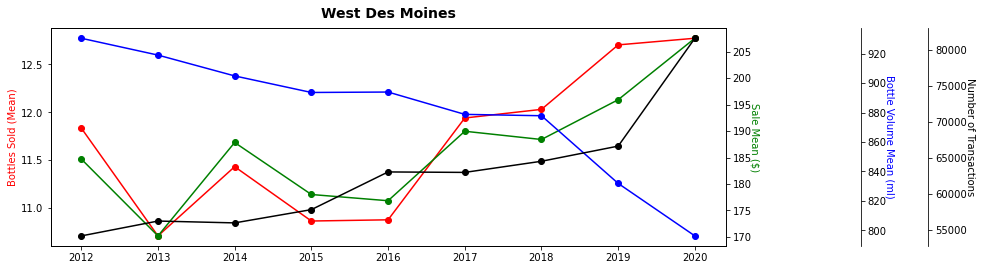

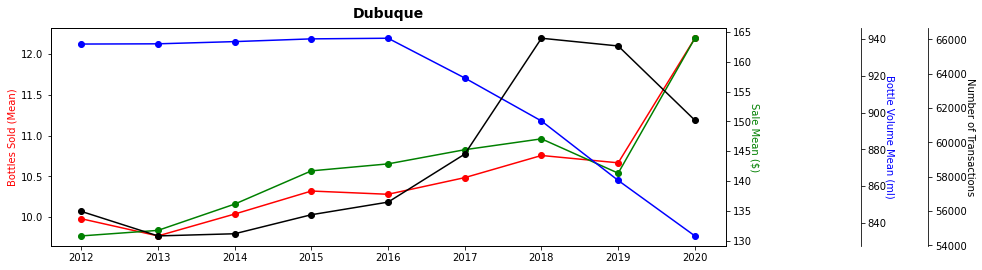

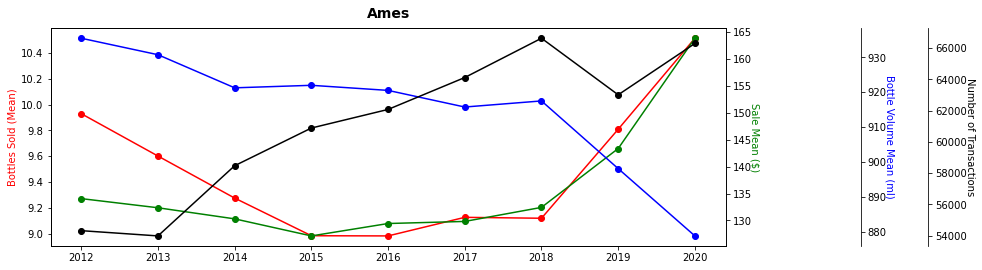

In [269]:
print("Sales and consumption trend across years based on cities :\n")

for x in high.groupby("city").sum()["bottles_sold"].sort_values(ascending = False).index:
    fig, ax = plt.subplots(figsize = (15, 4))
    fig.subplots_adjust(right = 0.75)

    temp = high[high["city"] == x]
    temp_ = temp.groupby("year").mean()[["bottles_sold", "sale_dollars", "bottle_volume_ml", "state_bottle_retail"]]
    temp_["no_transactions"] = temp.groupby("year").count()["date"]
    temp_.drop(2021, 0, inplace = True)
    
    ax.plot(temp_.index, temp_["bottles_sold"], color = "red", marker = "o")
    ax.set_ylabel(
        "Bottles Sold (Mean)",
        color = "red",
        fontsize = 10)

    ax2 = ax.twinx()
    ax2.plot(temp_.index, temp_["sale_dollars"], color = "green", marker = "o")
    ax2.set_ylabel(
        "Sale Mean ($)",
        fontdict = {
            "verticalalignment" : "center_baseline",
            "fontsize" : 10,
            "rotation" : 270,
            "color" : "green"
        })

    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.spines["right"].set_visible(True)
    ax3.plot(temp_.index, temp_["bottle_volume_ml"], color = "blue", marker = "o")
    ax3.set_ylabel(
        "Bottle Volume Mean (ml)",
        fontdict = {
            "verticalalignment" : "center_baseline",
            "fontsize" : 10,
            "rotation" : 270,
            "color" : "blue"
        })
    
    ax4 = ax.twinx()
    ax4.spines["right"].set_position(("axes", 1.3))
    ax4.spines["right"].set_visible(True)
    ax4.plot(temp_.index, temp_["no_transactions"], color = "black", marker = "o")
    ax4.set_ylabel(
        "Number of Transactions",
        fontdict = {
            "verticalalignment" : "center_baseline",
            "fontsize" : 10,
            "rotation" : 270,
            "color" : "black"
        })

    ax.set_title(
        f"{x}", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.02)
    
    plt.show()

In [270]:
print("Year with incomplete months :")
for x in high["year"].unique():
    if len(high[high["year"] == x]["month"].unique()) != 12:
        print(x)

Year with incomplete months :
2021


**We exclude 2021 because it's the only year which doesn't have complete months observations. So, it would not appropriate to include this year because we would end up in missconclusion. We use mean instead of count because each city each year produces a trend in transactions. So, if we don't consider number of transactions we would end up in missconclusion.**

We see an obvious downtrend of sold bottles volume throughout years. All cities reach their lowest volume consumption in 2020, meaning customers behaviour in buying liquor with high volume is constantly decreasing. Therefore, selling liquors in small volume would be more beneficial. Plot above also shows an increasing pattern of liquor consumption behaviour, especially from 2019 to 2020, except Dubuque and Iowa City. This means 2021 is a very potential year to increase sales. However, number of transactions itself doens't guarantee sales income. Take a look at Iowa City, Dubuque (2019 - 2020) and Des Moines (2019 - 2020) where income and transactions rate shows negative correlation. They suffer drops of transactions but got increment in income, vice versa. This phenomenon is believed caused by behaviour shifting in mentioned cities. People in Dos Moines (2019 - 2020) whose at previous time buying liquor in high amount of bottles changing their pattern to buying liquor in small amount of bottles. It infulences vendor's selling pattern. On the other hand, Dubuque (2019 - 2020) people tend to become more consumptive when they aren't used to. As a result, vendor's selling trend is going up. These unique behaviour for some cities is important in setting up future sales strategy.

Apart from that, high increment of transactions in 2020 is believed influenced by Corona virus pandemic, which force people to stay home for a long time. Hence, it increases liquor consumption.

## Top 10 Lowest Cities

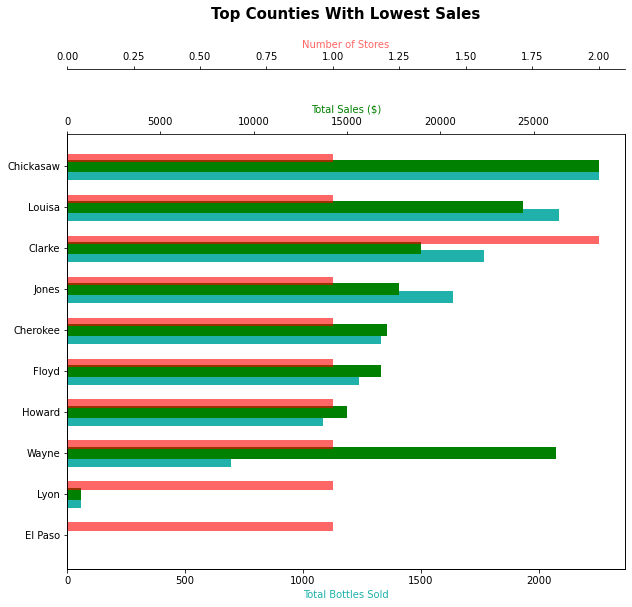

In [294]:
temp = low.groupby("county").sum()[["bottles_sold", "sale_dollars"]].sort_values("bottles_sold").reset_index()
res = []
for x in temp["county"]:
    res.append(len(low[low["county"] == x]["store_name"].unique()))
temp["stores"] = res

fig, ax = plt.subplots(figsize = (10, 8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.barh(temp.index - .2, temp["bottles_sold"],
       color = "lightseagreen",
       height = 0.3,
       linewidth = 1)

ax.set_title("Top Counties With Lowest Sales", fontdict = {'fontsize': 15,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.25)

ax.set_xlabel(
    "Total Bottles Sold",
    fontdict = {
        "size" : 10,
        "color" : "lightseagreen"
    }
    )

ax2 = ax.twiny()
ax2.barh(temp.index, temp["sale_dollars"],
       color = "green",
       height = 0.3,
       linewidth = 1)

ax2.set_xlabel(
    "Total Sales ($)",
    fontdict = {
        "size" : 10,
        "color" : "green"
    }
    )

ax3 = ax.twiny()
ax3.barh(temp.index + .2, temp["stores"],
       color = "red",
       alpha = 0.6,
       height = 0.2,
       linewidth = 1)

ax3.set_xlabel(
    "Number of Stores",
    fontdict = {
        "size" : 10,
        "color" : "red",
        "alpha" : 0.6
    }
    )

ax3.spines["top"].set_position(("axes", 1.15))
ax3.spines["top"].set_visible(True)

plt.yticks(([x for x in temp.index]), ([x for x in temp["county"]]))

plt.show()

Now we know why these counties have the lowest sales. The main reason is because they only have 2 stores at max. It means liquor isn't that favourite for the people. However, it seems like not every county has the same behaviour. El Paso is definitely not a potential county and thus we shouldn't put our concern at it. However, county like Chickasaw seems like has more alcoholic people eventough the stores number is just the same like Howard and even fewer than Clarke. Therefore, number of stores doesn't correlate at all with sales in this group, not like the highest cities group which number of stores still has a slight pattern.

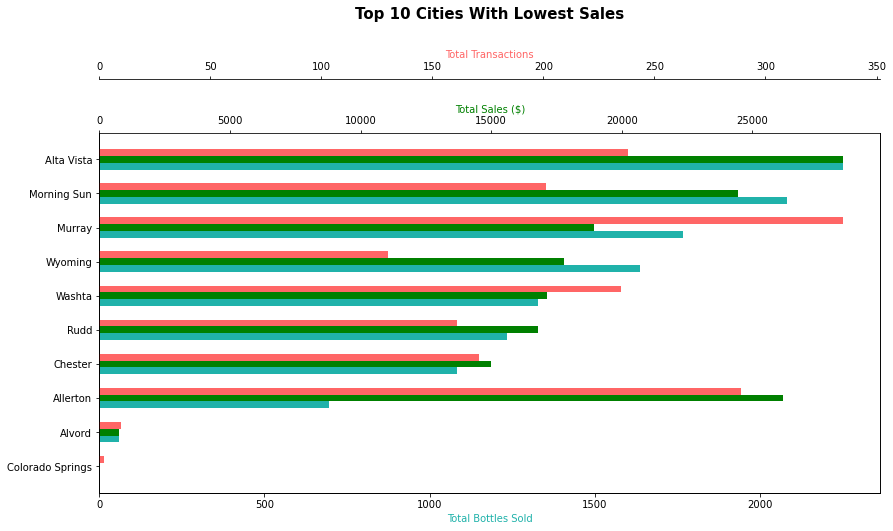

In [295]:
temp = low.groupby("city").sum()[["bottles_sold", "sale_dollars"]].sort_values("bottles_sold").reset_index()
temp_ = low.groupby("city").count()[["date"]].reset_index()
temp = temp.merge(temp_, on = "city")

fig, ax = plt.subplots(figsize = (14, 8))
fig.subplots_adjust(top = 0.75)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.barh(temp.index - .2, temp["bottles_sold"],
       color = "lightseagreen",
       height = 0.2,
       linewidth = 1)

ax.set_title("Top 10 Cities With Lowest Sales", fontdict = {'fontsize': 15,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.3)

ax.set_xlabel(
    "Total Bottles Sold",
    fontdict = {
        "size" : 10,
        "color" : "lightseagreen"
    }
    )

ax2 = ax.twiny()
ax2.barh(temp.index, temp["sale_dollars"],
       color = "green",
       height = 0.2,
       linewidth = 1)

ax2.set_xlabel(
    "Total Sales ($)",
    fontdict = {
        "size" : 10,
        "color" : "green"
    }
    )

ax3 = ax.twiny()
ax3.barh(temp.index + .2, temp["date"],
       color = "red",
       alpha = 0.6,
       height = 0.2,
       linewidth = 1)

ax3.set_xlabel(
    "Total Transactions",
    fontdict = {
        "size" : 10,
        "color" : "red",
        "alpha" : 0.6
    }
    )

ax3.spines["top"].set_position(("axes", 1.15))
ax3.spines["top"].set_visible(True)

plt.yticks(([x for x in temp.index]), ([x for x in temp["city"]]))

plt.show()

Allerton is a potential city when we talk about sales ($). Even though it has one of the lowest total bottles sold record, its income is the second highest. It means Allerton customers tend to buy high price liquor but in small numbers of bottles. This phenomenon is contradictory with Murray, which customers tend to buy cheaper liquor.

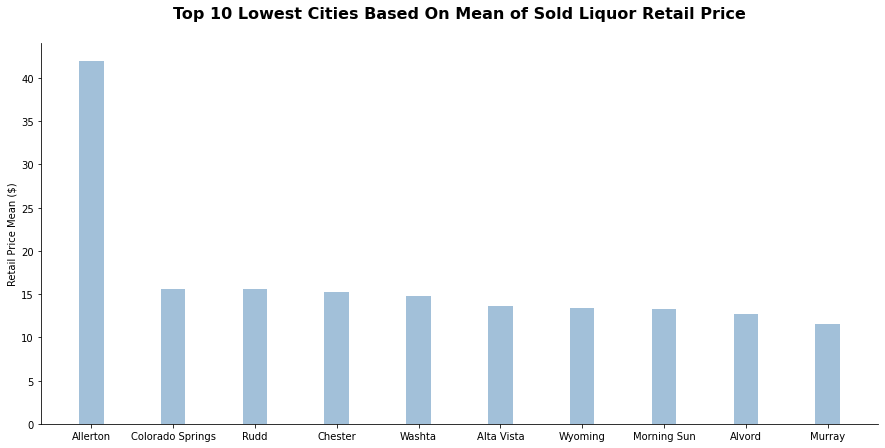

In [296]:
temp = low.groupby("city").mean().sort_values("state_bottle_retail", ascending = False)
fig, ax = plt.subplots(figsize = (15, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.bar(temp.index, temp["state_bottle_retail"],
       color = "steelblue",
       alpha = 0.5,
       width = 0.3,
       linewidth = 1)

plt.title("Top 10 Lowest Cities Based On Mean of Sold Liquor Retail Price", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05)

plt.ylabel(
    "Retail Price Mean ($)",
    fontdict = {
        "size" : 10
    }
    )

plt.show()

We can conclude that alcoholics in Allerton is one of the richest (maybe even the richest) between all cities. As stated before, transaction in this city is the second highest. No wonder if its sales ($) could surpass 8 other cities because with just even small amount of bottles sold, the sales income they got is increasing significantly.

In [360]:
temp = pd.DataFrame({"City" : [x for x in low["city"].unique()], "Customers" : [len(x) for x in [low[low["city"] == c]["store_name"].unique() for c in low["city"].unique()]]}).sort_values("Customers", ascending = False).set_index("City")

print("Number of customers per city :\n")
display(temp)

Number of customers per city :



,Customers
City,
Murray,2
Chester,1
Allerton,1
Rudd,1
Alta Vista,1
Morning Sun,1
Washta,1
Wyoming,1
Alvord,1


Not many stores exist in these cities, meaning it would be hard to sell same products between vendors. However, this would be a wonderful opportunity for vendor whose know what's the most wanted product and how to sell it properly.

In [300]:
arrays = [
   [y for y in low["city"].unique() for x in range(2)],
    [y for x in range(10) for y in ["Store", "Transactions"]],
  ]

columns = pd.MultiIndex.from_tuples(list(zip(*arrays)))
temp = pd.DataFrame(columns = columns, index = [x for x in range(2)])

for x in low["city"].unique():
    stores = low[low["city"] == x].groupby("store_name").count()["date"].sort_values(ascending = False)
    temp[x] = pd.DataFrame({"Store" : [x for x in stores.index[:2]], "Transactions" : [x for x in stores.values[:2]]})

print("Highest store distributions per city :\n")
display(temp)

Highest store distributions per city :



Chester                                             Murray  \
                   Store Transactions                                 Store   
0  Laddy's Bar And Grill  171          Crazy Mary's Licker                    
1  NaN                    NaN          Casey's General Store #3332 / Murray   

                                   Allerton               \
  Transactions                        Store Transactions   
0  227          Whiskey Business / Allerton  289           
1  108          NaN                          NaN           

                     Rudd                 Alta Vista               \
                    Store Transactions         Store Transactions   
0  R & R Town Mart / Rudd  161          A. V. Liquor  238           
1  NaN                     NaN          NaN           NaN           

                               Morning Sun               \
                                     Store Transactions   
0  Casey's General Store #74 - Morning Sun  201           
1  NaN                                      NaN           

                       Washta               \
                        Store Transactions   
0  B & K One Stop LLC, Washta  235           
1  NaN                         NaN           

                                 Wyoming                               Alvord  \
                                   Store Transactions                   Store   
0  Casey's General Store #1126 / Wyoming  130          Direct Liquor / Alvord   
1  NaN                                    NaN          NaN                      

               Colorado Springs               
  Transactions            Store Transactions  
0  10           Dash Events LLC  2            
1  NaN          NaN              NaN

Looks like Casey's General Store is the only customer which is well distributed. It exists in 3 out of 10 cities in this group. Hence Casey's is a very potential customer because it can reach broader are and alcoholics.

In [359]:
print("Total vendors per city :\n")
temp = low["city"].unique()
temp_ = pd.DataFrame(
    {
        "Total Vendors" : [len(low[low["city"] == x]["vendor_name"].unique()) for x in temp]
    }, index = [x for x in temp]
).sort_values("Total Vendors", ascending = False)

display(temp_)

Total vendors per city :



,Total Vendors
Murray,43
Allerton,38
Wyoming,20
Morning Sun,19
Alta Vista,18
Washta,18
Rudd,17
Chester,14
Alvord,3
Colorado Springs,1


Besides Allerton, Wyoming is also a potential city. Considering its quite low vendors number, it should be considered if a seller wants to target quantity selling.

Favorite products based on cities :



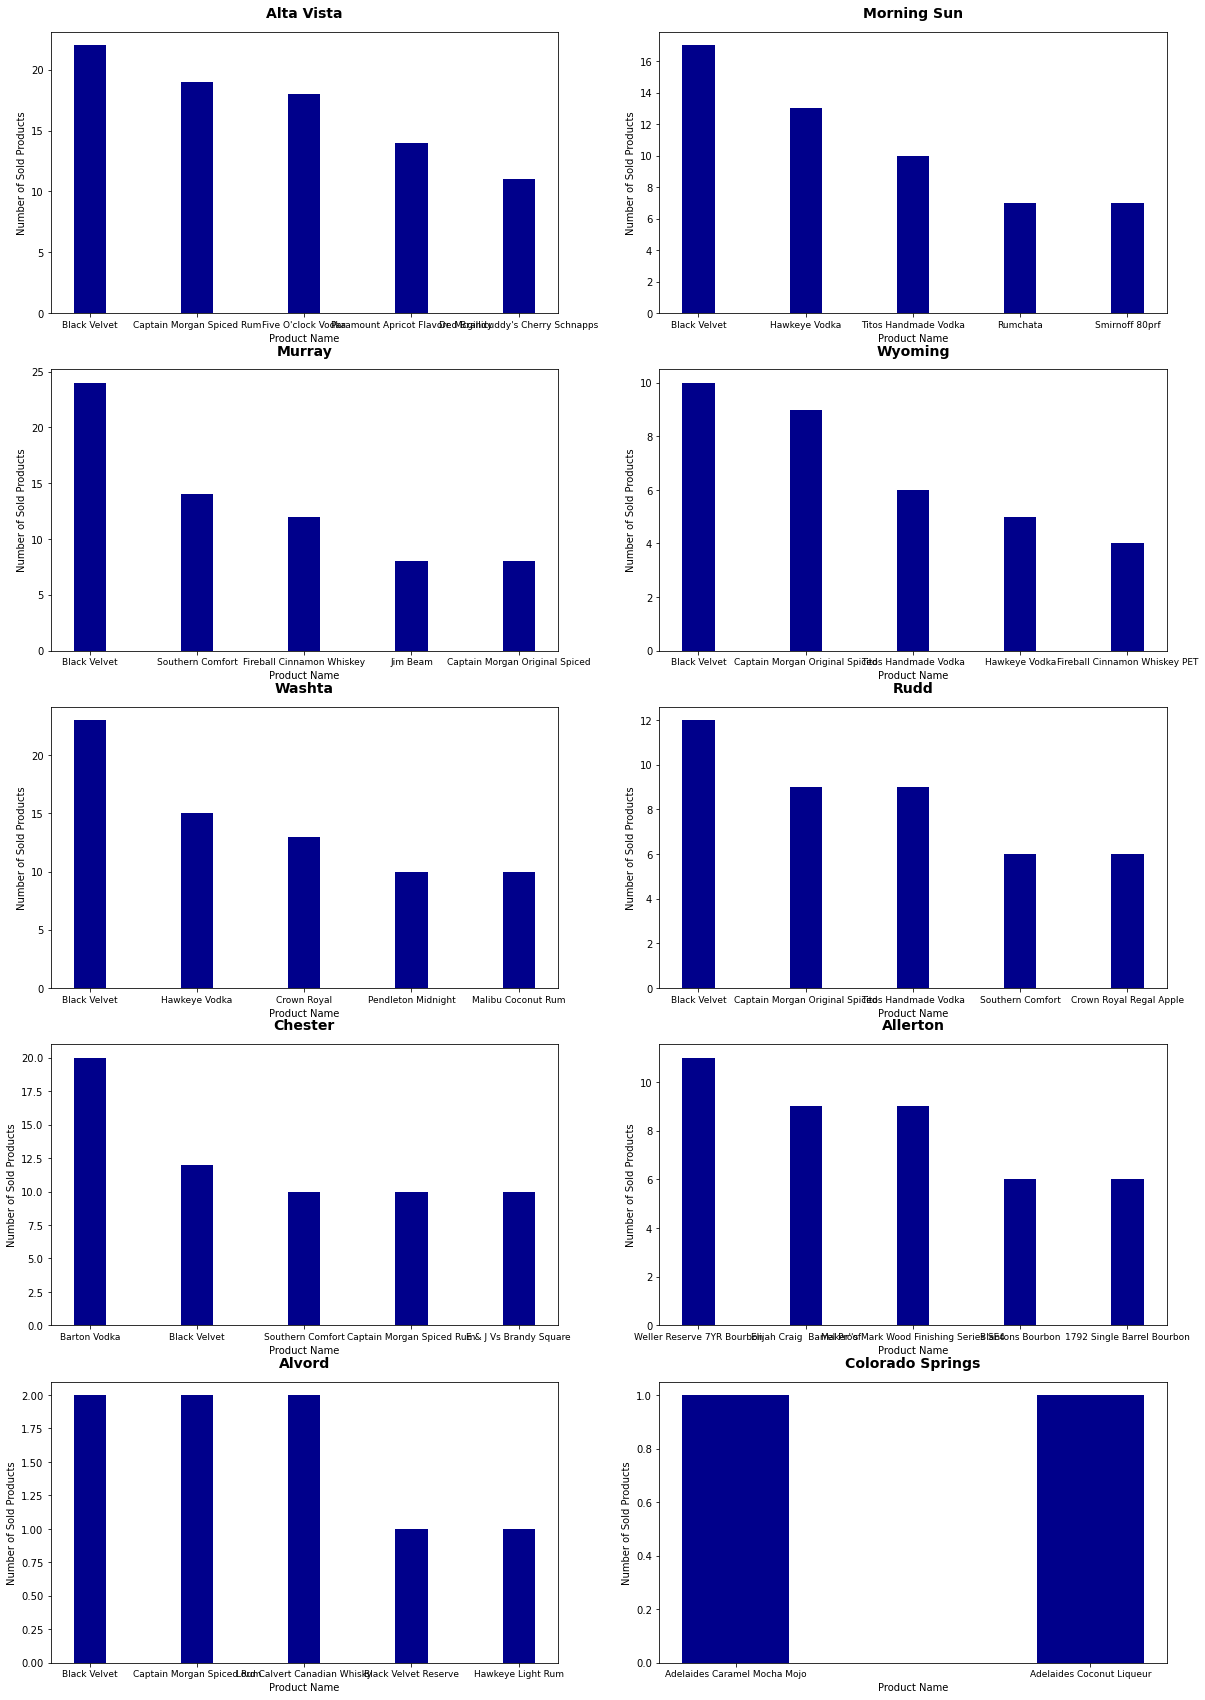

In [301]:
row, col = 0, 0

print("Favorite products based on cities :\n")
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in low.groupby("city").sum()["bottles_sold"].sort_values(ascending = False).index: 
    if col > 1:
        col = 0
        row += 1
        
    temp = low[low["city"] == x].groupby("item_description").count().sort_values("date", ascending = False)[:5]
    
    ax[row][col].bar([x for x in temp.index], [x for x in temp["date"]], width = 0.3, color = "darkblue")
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 14,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Product Name",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Number of Sold Products",
        fontdict = {
            "size" : 10
        }
        )
    
    ax[row][col].set_xticklabels(
            labels = [x for x in temp.index],
            fontdict = {
            "fontsize": "9"
            }
        )
    
    col += 1

It's amazing how Black Velvet is being loved in either top 10 highest and lowest cities. Almost all cities in this group love Black Velvet and thus make it as a top gainer product. Vendors should consider putting this product as their top concern in marketing and sales since it could give a very beneficial business value.

In [336]:
print("Observations based on year per city :\n")
for x in low["city"].unique():
    print(f"{x} :")
    for y in low[low["city"] == x]["year"].unique():
        print(f"-{y}")

Observations based on year per city :

Chester :
-2012
Murray :
-2013
-2020
-2012
-2021
Allerton :
-2020
-2021
Rudd :
-2019
-2020
-2021
Alta Vista :
-2012
-2014
-2013
Morning Sun :
-2019
-2020
Washta :
-2016
-2018
-2017
-2019
Wyoming :
-2020
-2021
Alvord :
-2012
Colorado Springs :
-2018


Because of incomplete years for each city, we can't perform time based analysis.

# Conclusion and Recommendation

- 2021 is a perfect year for either new or old vendors to join the competition because liquor consumption is increasing in a high trend. Even though it may not increases as high as 2020 (because 'stay at home' hype is not that big anymore in 2021 ; people are getting use to do activities slowly despite of the pandemic), but 2021 is still a decent year.
- It is very recommended for vendors to compete in selling Black Velvet liquor using discount, promos, or other marketing strategies because it's the most liked product in either highest or lowest cities group. Putting this product in concern could significantly increases sales and income.
- Stop selling liquor above 750ml because consuming higher volume of liquor is not a trend anymore. There's a chance if a vendor selling liquor with high volume nowadays, it will suffer from warehouse stock that piles up and thus potentially hinder cash flow.
- If a vendor choose to compete in Ames, don't sell expensive product because it will slow up the sales.
- Considering sellers competition, vendor should considered reaching West Des Moines or Waterloo. They have fewer settled vendors, thus giving more opportunity rather than Des Moines. If a vendor wants to sell more expensive products, it can choose West Des Moines because it has higher buying power than Waterloo. However, its customers tend to buy in small amount of products. Otherwise, if a vendor wants to target quantity selling it should reach Waterloo since its customers tend to buy products in high amount of number. But, the downside is that Waterloo has lower buying power so it musn't sell expensive liquors.
- New seller is very recommended to compete in Allerton. Its record is not as good as Des Moines for example, but it got a good potential. But, vendor must pay attention to which product they should sell. Customers in Allerton has a very high buying power compared to the others. While most of the cities love Black Velvet, Allerton loves more expensive products, like Weller Reserve 7YR Bourbon	 and Elijah Craig product line (Elijah Craig 18YR and Elijah Craig Barrel Proof). So, vendor is suggested to focus on these kind of products.
- In general, it is recommended to sell and distribute products to Hy-Vee and Casey's General Store. Both of them have the highest reach among two cities groups. It also means people tend to prefer buying liquors in those stores.